In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from pathlib import Path

In [3]:
import sys
sys.path.append("..")
sys.path.append("../source")
# sys.path.append("../source/datasets")

In [4]:
from datasets.ptz_dataset import PTZImageDataset
from transforms import make_transforms
from gen_embed import generate_embedding
from utils.analysis_viz import read_train_loss, flatten

/opt/homebrew/Caskroom/miniconda/base/envs/sage/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniconda/base/envs/sage/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <9E1A0B70-7AFB-30E2-B230-74CF804853DE> /opt/homebrew/Caskroom/miniconda/base/envs/sage/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <51359D84-6AD7-3580-B6FC-DD9B642AEA0E> /opt/homebrew/Caskroom/miniconda/base/envs/sage/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
img_dir = Path("/Users/yufengluo/Research/anl/su24/data/collected_imgs")
code_dir = Path("/Users/yufengluo/Research/anl/su24/PTZJEPA")
model_dir = Path("/Users/yufengluo/Research/anl/su24/trainings/camera-train/world_model/model_94")
infer_dir = model_dir / "inference"

In [6]:
infer_dir.mkdir(exist_ok=True)

In [7]:
dataset = PTZImageDataset(img_dir, transform=make_transforms(), return_label=True)

INFO:data_transforms:making ptz image data transforms


In [8]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

In [9]:
import sys
sys.path.append("../source")
from datasets.ptz_dataset import PTZImageDataset, get_position_datetime_from_labels

In [10]:
# img, label = next(iter(dataloader))
# pos = torch.tensor(get_position_datetime_from_labels(label)[0])
# pos = pos.to("mps", non_blocking=True, dtype=torch.float32)

# Inference and diagnostics

In [11]:
all_train, header = read_train_loss(model_dir / "jepa.csv")
df = pd.DataFrame(flatten(all_train), columns=header, dtype=float)
x_axis = np.array([row.epoch + row.itr/df.query("epoch==@row.epoch").itr.max() for row in df.itertuples()],
                  dtype=float)

Text(0, 0.5, 'loss')

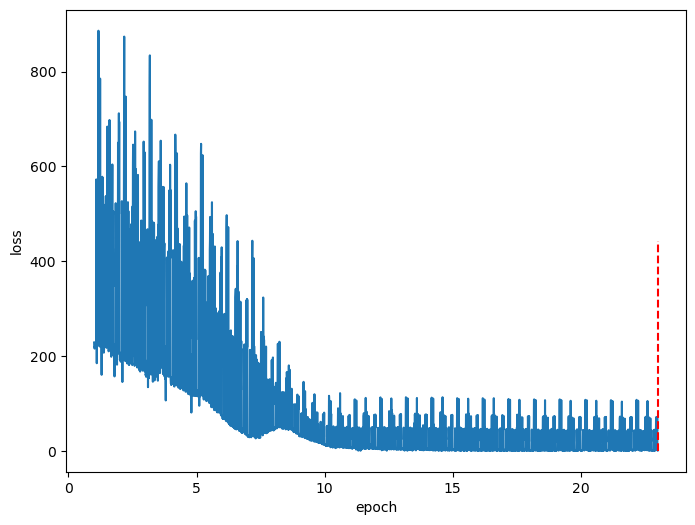

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(x_axis, df['loss'], "-")
for i in np.unique(df.restart):
    plt.vlines(x_axis[df.query("restart==@i").index[-1]], ymin=0, ymax=df['loss'].max()/2, color='r', linestyles='dashed')
# plt.vlines(x_axis[df.query("restart==0").index[-1]], ymin=0, ymax=300, color='r', linestyles='dashed')
plt.xlabel('epoch')
plt.ylabel('loss')

In [13]:
generate_embedding(model_dir / "params-ijepa.yaml", model_dir / "jepa-latest.pth.tar",
                   img_dir, infer_dir, world_model=True, device="mps", in_chans=4)

INFO:gen_embed:Loading parameters
INFO:gen_embed:Loading model
INFO:helper:VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(4, 192, kernel_size=(14, 14), stride=(14, 14))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=Tru

# Read the results

In [10]:
import h5py
import os

In [11]:
os.listdir(infer_dir)

['cluster_8',
 'cluster_6',
 '.DS_Store',
 'cluster_1',
 'embeds_contx_encoder.npy',
 'cluster_0',
 'cluster_7',
 'cluster_9',
 'rewards_predictor.npy',
 'cluster_10',
 'cluster_17',
 'cluster_19',
 'cluster_18',
 'cluster_20',
 'cluster_16',
 'cluster_11',
 'embeds_contx_encoder.h5',
 'embeds_target_encoder.h5',
 'embeds_predictor.h5',
 'embeds_target_encoder.npy',
 'labels.txt',
 'cluster_2',
 'cluster_5',
 'cluster_4',
 'cluster_3',
 'cluster_14',
 'cluster_13',
 'cluster_12',
 'cluster_15',
 'embeds_predictor.npy']

In [12]:
batch_size = 4

In [13]:
reward = np.load(infer_dir / "rewards_predictor.npy", allow_pickle=True)
reward = np.mean(reward, axis=1)
reward = reward.reshape(-1, batch_size, 1)

In [14]:
with open(infer_dir / "labels.txt") as f:
    labels = [l.strip() for l in f if l.strip()]

In [15]:
from utils.analysis_viz import sort_by_time_from_label, read_fname_embed_from_h5, scale_pca_tsne_transform

In [16]:
pred_fnames, pred_embeds = read_fname_embed_from_h5(infer_dir / "embeds_predictor.h5")
contx_fnames, contx_embeds = read_fname_embed_from_h5(infer_dir / "embeds_contx_encoder.h5")
target_fnames, target_embeds = read_fname_embed_from_h5(infer_dir / "embeds_target_encoder.h5")

In [17]:
pred_embed_sort, *pred_meta = sort_by_time_from_label(pred_embeds, pred_fnames)
contx_embed_sort, *contx_meta = sort_by_time_from_label(contx_embeds, contx_fnames)
target_embed_sort, *target_meta = sort_by_time_from_label(target_embeds, target_fnames)

In [18]:
import pandas as pd

In [19]:
df_pred = pd.DataFrame(pred_meta, index=["fnames", "pos", "time"]).T
df_contx = pd.DataFrame(contx_meta, index=["fnames", "pos", "time"]).T
df_target = pd.DataFrame(target_meta, index=["fnames", "pos", "time"]).T

In [20]:
pred_embed_avg = np.mean(pred_embed_sort, axis=2)
contx_embed_avg = np.mean(contx_embed_sort, axis=2)
target_embed_avg = np.mean(target_embed_sort, axis=2)

In [21]:
pred_embed_avg.shape, contx_embed_avg.shape, target_embed_avg.shape

((6048, 4, 192), (6048, 4, 192), (6048, 4, 192))

# Demonstrate the prediction results

The order of context & pred images are 0000 1111 2222 3333 .... 

The order of target images is 0123 0123 0123 ....

So the predictor should have a behavior closely resemble the target images,
but not exactly the same.

The zero norm values mean that the target and context encoders are producing the
same output for the same image. This is just a sanity check to make sure the
encoders are working correctly.

In [22]:
batch_size = 4

In [23]:
from numpy import linalg

In [24]:
linalg.norm(contx_embed_avg[:, 0] - contx_embed_avg[:, batch_size-1])

0.0

In [25]:
print(linalg.norm(target_embed_avg[0, :] - target_embed_avg[batch_size-2, :]))
print(linalg.norm(target_embed_avg[0, :] - target_embed_avg[batch_size-1, :]))
print(linalg.norm(target_embed_avg[0, :] - target_embed_avg[batch_size, :]))
# print(linalg.norm(target_embed_avg[5, :] - target_embed_avg[7, :]))

0.0
0.0
2.899889


# Remove Nan images

In [26]:
image_idx, *_ = np.where(np.isnan(pred_embed_avg))
image_idx = np.unique(image_idx)

In [27]:
print("\n".join([labels[i] for i in image_idx]))

147.96,-0.0,1.0_2024-06-21_00:24:32.665544
148.21,-9.99,1.0_2024-06-21_00:24:36.082236
138.2,-7.99,101.0_2024-06-21_00:24:39.491235
138.4,-7.79,101.0_2024-06-21_00:24:42.087950
-16.98,-30.19,101.0_2024-06-21_02:20:50.255127
-26.99,-20.19,201.0_2024-06-21_02:20:53.662155
-26.99,-20.19,201.0_2024-06-21_02:20:55.014995
-46.99,-9.99,101.0_2024-06-21_02:20:58.428492
-50.99,-9.99,246.0_2024-06-21_02:21:17.385730
-50.99,-9.95,246.0_2024-06-21_02:21:18.749611
-53.0,-0.0,46.0_2024-06-21_02:21:22.189441
-53.19,-0.0,1.0_2024-06-21_02:21:25.597948
161.01,-40.19,1071.0_2024-06-21_02:32:15.662754
160.98,-40.27,1071.0_2024-06-21_02:32:17.019315
153.02,-44.18,1171.0_2024-06-21_02:32:20.459534
152.78,-44.18,1171.0_2024-06-21_02:32:21.824230


In [28]:
from PIL import Image

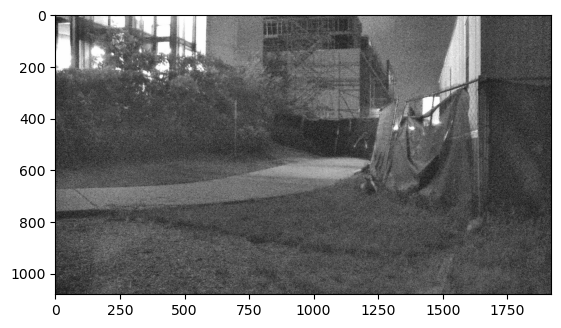

In [29]:
with Image.open(img_dir / (labels[image_idx[10]] + ".jpg")) as img:    plt.imshow(img)

In [30]:
# remove images with nan in the embedding
pred_embed_avg = np.delete(pred_embed_avg, image_idx, axis=0)
contx_embed_avg = np.delete(contx_embed_avg, image_idx, axis=0)
target_embed_avg = np.delete(target_embed_avg, image_idx, axis=0)
reward = np.delete(reward, image_idx, axis=0)
pred_fnames = np.delete(pred_fnames, image_idx)

In [31]:
print(linalg.norm(pred_embed_avg[:, 0] - pred_embed_avg[:, 3]))
print(linalg.norm(pred_embed_avg[0, :] - pred_embed_avg[3, :]))

235.14064
0.29021046


# Dimensionality reduction

In [32]:
# now downsample the embeddings based on the ordering
samp_target_embed = target_embed_avg[::batch_size, :]
samp_target_embed = samp_target_embed.reshape(-1, samp_target_embed.shape[-1])
samp_contx_embed = contx_embed_avg[:, 0]

In [33]:
linalg.norm(samp_target_embed - samp_contx_embed)

19.092484

In [34]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
import joblib

In [35]:
trans_contx_embeds = scale_pca_tsne_transform(samp_contx_embed)
# trans_pred_embeds = scale_pca_tsne_transform(pred_embed_avg)
trans_target_embeds = scale_pca_tsne_transform(samp_target_embed)

In [36]:
reward.shape

(6032, 4, 1)

# Clustering analysis

In [37]:
pred_self = np.zeros((pred_embed_avg.shape[0], pred_embed_avg.shape[-1]))
reward_self = np.zeros((reward.shape[0], reward.shape[-1]))
# 3 per batch
pred_dist_one = np.zeros((int(pred_embed_avg.shape[0]*3/4), pred_embed_avg.shape[-1]))
reward_one = np.zeros((int(reward.shape[0]*3/4), reward.shape[-1]))
# 2 per batch
pred_dist_two = np.zeros((int(pred_embed_avg.shape[0]/2), pred_embed_avg.shape[-1]))
reward_two = np.zeros((int(reward.shape[0]/2), reward.shape[-1]))
# 1 per batch
pred_dist_three = np.zeros((int(pred_embed_avg.shape[0]/4), pred_embed_avg.shape[-1]))
reward_three = np.zeros((int(reward.shape[0]/4), reward.shape[-1]))
label_self = []
label_one_one = []
label_one_two = []
label_one_three = []
for i, arr in enumerate(pred_embed_avg):
    pred_self[i] = arr[i % batch_size]
    reward_self[i] = reward[i, i % batch_size]
    label_self.append(labels[i])
    if i % batch_size == 3:
        continue
    remind = i % batch_size
    pred_dist_one[(i//batch_size)*3 + remind] = arr[1+remind]
    reward_one[(i//batch_size)*3+remind] = reward[i, 1+remind]
    if i % batch_size == 2:
        continue
    pred_dist_two[(i//batch_size)*2 + remind] = arr[2+remind]
    reward_two[(i//batch_size)*2+remind] = reward[i, 2+remind]
    if i % batch_size == 1:
        continue
    pred_dist_three[i//batch_size] = arr[3]
    reward_three[i//batch_size] = reward[i, 3]

In [38]:
trans_pred_one = scale_pca_tsne_transform(pred_dist_one)
trans_pred_two = scale_pca_tsne_transform(pred_dist_two)
trans_pred_three = scale_pca_tsne_transform(pred_dist_three)

In [39]:
trans_pred_self = scale_pca_tsne_transform(pred_self)

(-80.0, 80.0)

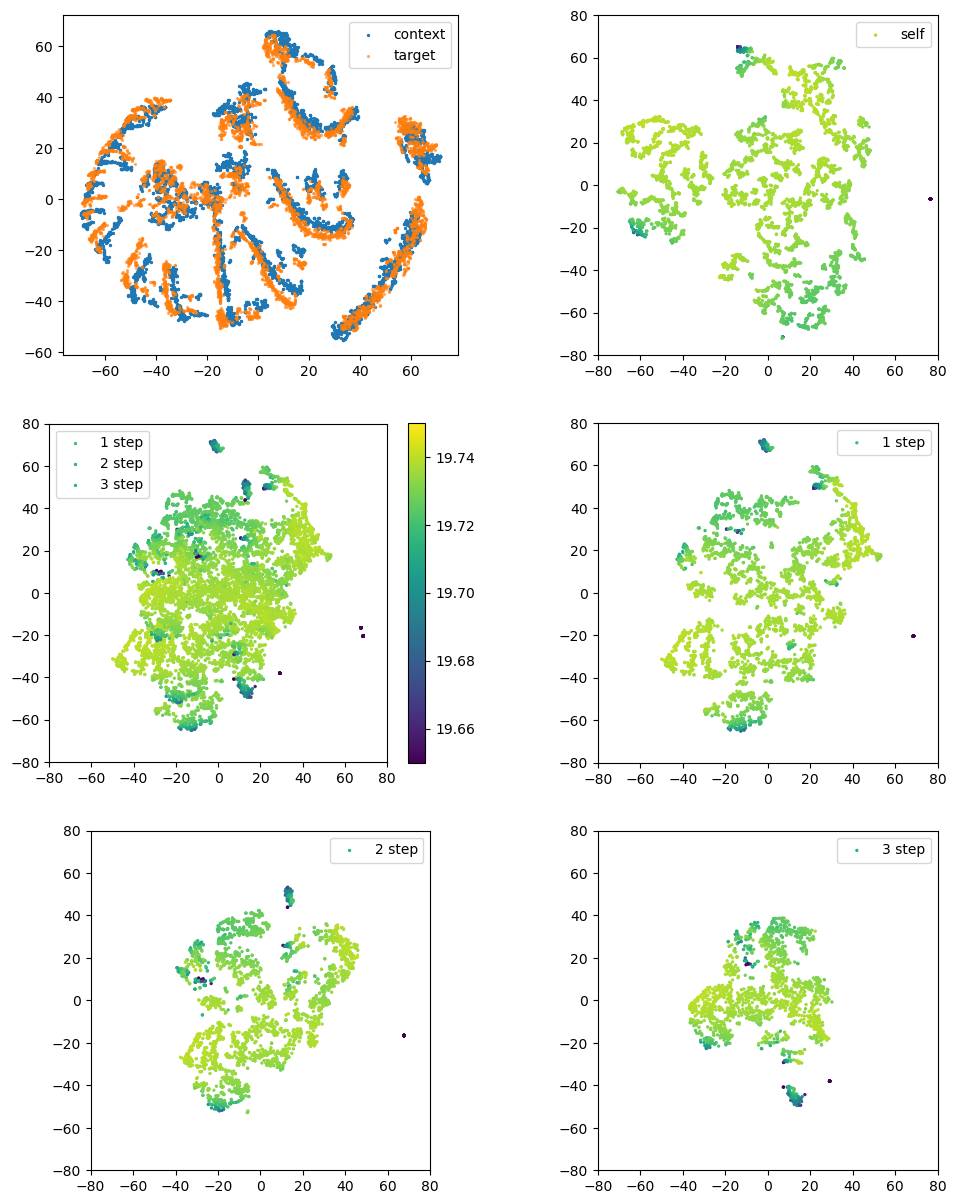

In [52]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))
plt.set_cmap("viridis")
ax = ax.ravel()
ax[0].scatter(trans_contx_embeds[0][:, 0], trans_contx_embeds[0][:, 1], s=2, label="context")
ax[0].scatter(trans_target_embeds[0][:, 0], trans_target_embeds[0][:, 1], s=2, alpha=0.5, label="target")
ax[0].legend()
ax[0].set_aspect("equal")

vmin = 19.65
vmax = 19.75
ax[1].scatter(trans_pred_self[0][:, 0], trans_pred_self[0][:, 1], s=2, label="self",
              c=reward_self.flatten(), vmin=vmin, vmax=vmax)
ax[1].set_aspect("equal")
ax[1].legend()
ax[1].set_xlim([-80, 80])
ax[1].set_ylim([-80, 80])


ax[2].scatter(trans_pred_one[0][:, 0], trans_pred_one[0][:, 1], s=2, label="1 step",
              c=reward_one.flatten(), vmin=vmin, vmax=vmax)
ax[2].scatter(trans_pred_two[0][:, 0], trans_pred_two[0][:, 1], s=2, label="2 step",
              c=reward_two.flatten(), vmin=vmin, vmax=vmax)
ax[2].scatter(trans_pred_three[0][:, 0], trans_pred_three[0][:, 1], s=2, label="3 step",
              c=reward_three.flatten(), vmin=vmin, vmax=vmax)
ax[2].legend()
ax[2].set_aspect("equal")
ax[2].set_xlim([-80, 80])
ax[2].set_ylim([-80, 80])
fig.colorbar(ax[2].collections[0], ax=ax[2])

ax[3].scatter(trans_pred_one[0][:, 0], trans_pred_one[0][:, 1], s=2, label="1 step",
              c=reward_one.flatten(), vmin=vmin, vmax=vmax)
ax[3].legend()
ax[3].set_aspect("equal")
ax[3].set_xlim([-80, 80])
ax[3].set_ylim([-80, 80])

ax[4].scatter(trans_pred_two[0][:, 0], trans_pred_two[0][:, 1], s=2, label="2 step",
              c=reward_two.flatten(), vmin=vmin, vmax=vmax)
ax[4].legend()
ax[4].set_aspect("equal")
ax[4].set_xlim([-80, 80])
ax[4].set_ylim([-80, 80])

ax[5].scatter(trans_pred_three[0][:, 0], trans_pred_three[0][:, 1], s=2, label="3 step",
              c=reward_three.flatten(), vmin=vmin, vmax=vmax)
ax[5].legend()
ax[5].set_aspect("equal")
ax[5].set_xlim([-80, 80])
ax[5].set_ylim([-80, 80])

# ax[5].axis("off")

# Analyze the reward statistics

Text(0.5, 0, 'reward')

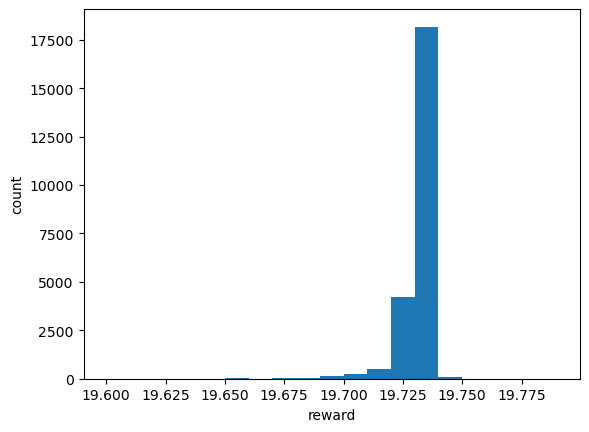

In [50]:
plt.hist(reward.flatten(), bins=np.arange(19.6, 19.8, 0.01))
# plt.xlim([12, 13])
plt.ylabel("count")
plt.xlabel("reward")

In [45]:
pd.DataFrame(reward.ravel(), columns=["reward"]).describe()

,reward
count,24128.000000
mean,19.218393
std,3.086592
min,0.697178
25%,19.730167
50%,19.735210
75%,19.736996
max,19.741129


In [46]:
pd.DataFrame(reward_one).describe()

,0
count,4524.000000
mean,19.358038
std,2.643809
min,0.697178
25%,19.730068
50%,19.735114
75%,19.736959
max,19.741070


In [47]:
pd.DataFrame(reward_two).describe()

,0
count,3016.000000
mean,19.378273
std,2.569958
min,0.697178
25%,19.729243
50%,19.734707
75%,19.736849
max,19.741068


In [48]:
pd.DataFrame(reward_three).describe()

,0
count,1508.000000
mean,19.440465
std,2.333435
min,0.697178
25%,19.728142
50%,19.734412
75%,19.736769
max,19.740345


In [49]:
pd.DataFrame(reward_self).describe()

,0
count,6032.000000
mean,19.219120
std,3.086990
min,0.697178
25%,19.730960
50%,19.735472
75%,19.737049
max,19.740147


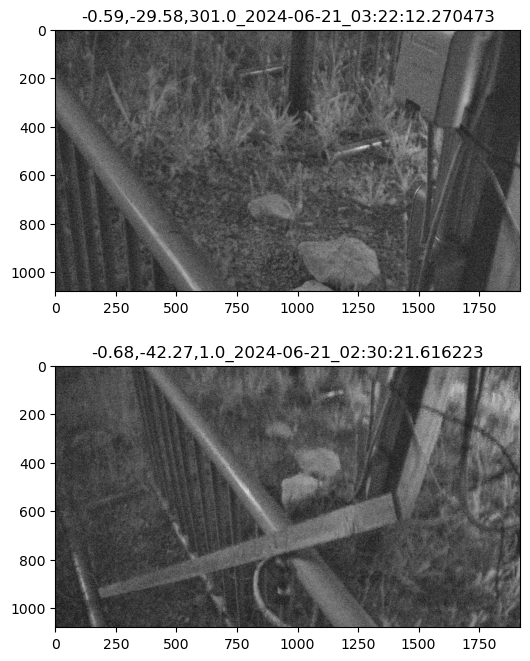

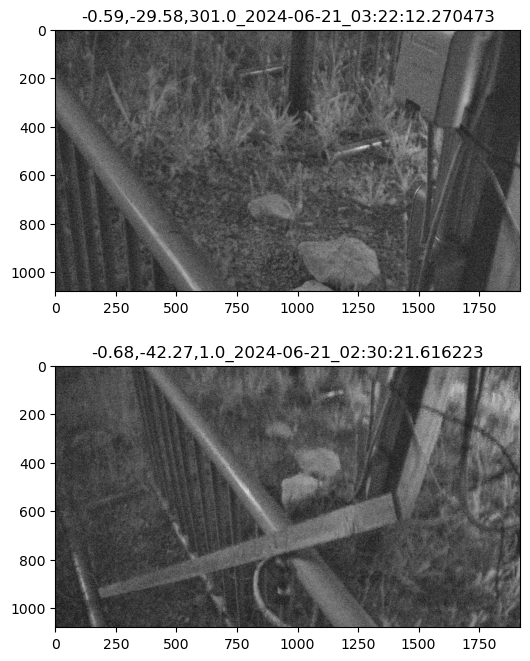

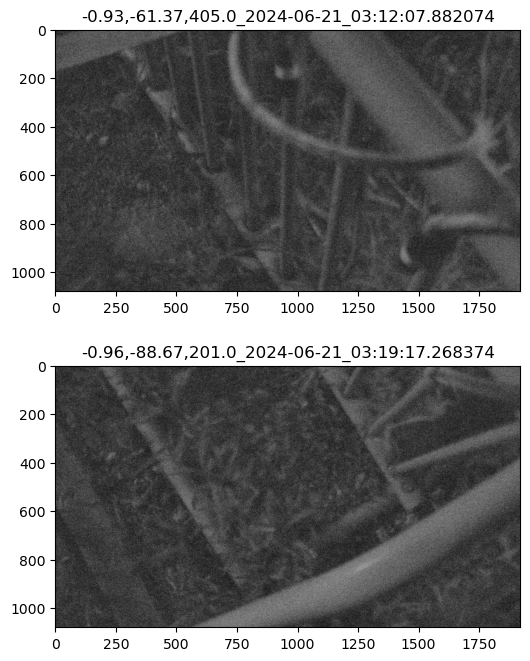

In [116]:
idx = np.where(reward_two < 10)[0]
ori_fnames = pred_fnames[idx // 2 * batch_size]
comp_fnames = pred_fnames[idx // 2 * batch_size + 2]
for pick_idx in range(3):
    fig, ax = plt.subplots(2, 1, figsize=(6, 8))
    ax[0].imshow(plt.imread(img_dir / (ori_fnames[pick_idx] + ".jpg")))
    ax[0].set_title(ori_fnames[pick_idx])
    ax[1].imshow(plt.imread(img_dir / (comp_fnames[pick_idx] + ".jpg")))
    ax[1].set_title(comp_fnames[pick_idx])
    plt.show()

# Check clusters

In [53]:
trans_contx_embeds[0].shape

(6032, 2)

In [54]:
# check clusters in the context and target embeddings
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score

# kmeans = KMeans(n_clusters=3, random_state=0).fit(trans_contx_embeds[0])
# contx_labels = kmeans.labels_
dbscan = DBSCAN(eps=3, min_samples=5, n_jobs=-1)
contx_clusters = dbscan.fit_predict(trans_contx_embeds[0])
tar_clusters = dbscan.fit_predict(trans_target_embeds[0])

In [55]:
all_embeds = np.vstack([trans_contx_embeds[0], trans_target_embeds[0]])

In [56]:
# Calculate the best clusters with the highest silhouette score
best_score = -1
best_eps = None
best_min_samples = None

for eps in np.arange(0.1, 1.0, 0.1):  # Example range for eps
    for min_samples in range(2, 10):  # Example range for min_samples
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(all_embeds)
        
        # We calculate silhouette score only if there's more than one cluster and less than len(X)-1 noise points
        if len(set(labels)) > 1 and np.count_nonzero(labels == -1) < all_embeds.shape[0] - 1:
            score = silhouette_score(all_embeds, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
print(f"Best silhouette score: {best_score}")
print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")

Best silhouette score: 0.288905531167984
Best eps: 0.4
Best min_samples: 2


In [57]:
dbscan = DBSCAN(eps=2, min_samples=2, n_jobs=-1) # DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1)
all_clusters = dbscan.fit_predict(all_embeds)
contx_clusters = all_clusters[:len(contx_clusters)]
tar_clusters = all_clusters[len(contx_clusters):]

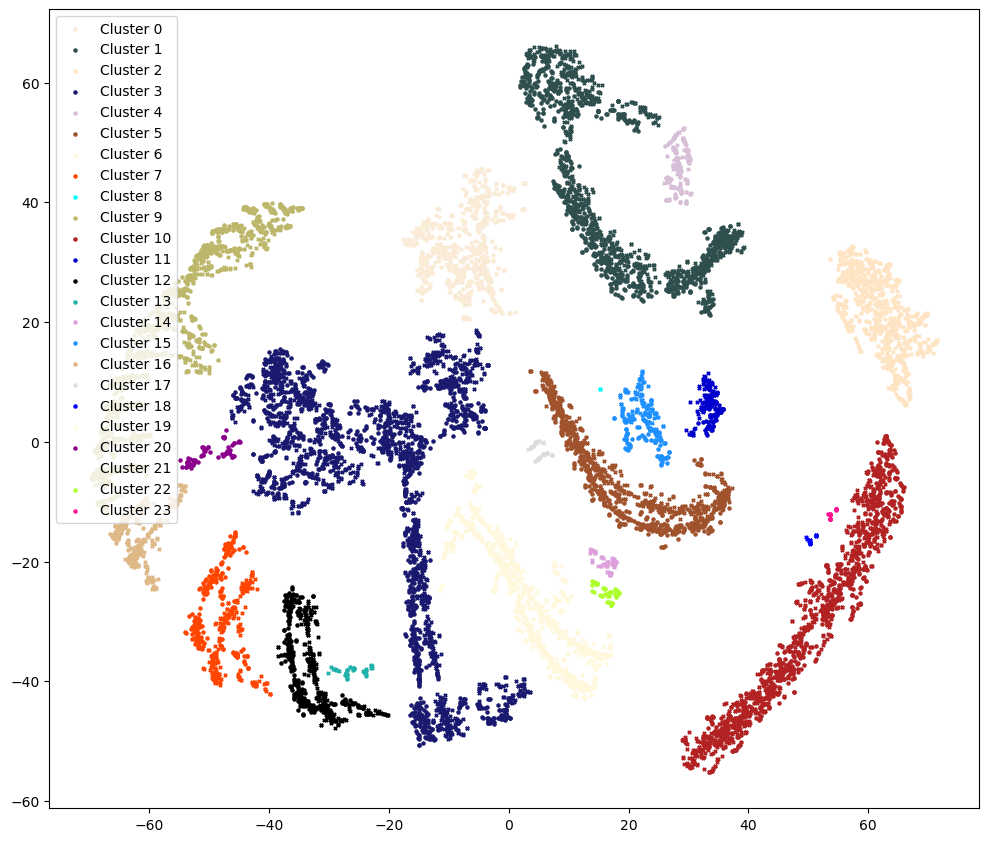

In [68]:
import matplotlib.colors as mcolors
import random

c_keys = list(mcolors.CSS4_COLORS.keys())
random.seed(10)
random.shuffle(c_keys)
colors = {i: mcolors.CSS4_COLORS[k] for i, k in enumerate(c_keys[::4])}

plt.figure(figsize=(12, 12))
for i in np.unique(all_clusters):
    plt.scatter(trans_contx_embeds[0][contx_clusters == i, 0],
                trans_contx_embeds[0][contx_clusters == i, 1], s=5, marker='x', c=colors[(i+1) % len(colors)])
    plt.scatter(trans_target_embeds[0][tar_clusters == i, 0],
                trans_target_embeds[0][tar_clusters == i, 1], s=5, c=colors[(i+1) % len(colors)], label=f"Cluster {i}")
# plt.scatter(trans_target_embeds[0][:, 0], trans_target_embeds[0][:, 1], s=2, label="target", c='tab:blue')
# plt.scatter(trans_contx_embeds[0][:, 0], trans_contx_embeds[0][:, 1], s=2, label="context", c='tab:orange')
# plt.scatter(trans_target_embeds[0][tar_clusters == i, 0],
#             trans_target_embeds[0][tar_clusters == i, 1], label=f"target Cluster-{i}", s=2, c='red')
# plt.scatter(trans_contx_embeds[0][contx_clusters == i, 0],
#             trans_contx_embeds[0][contx_clusters == i, 1], label=f"context Cluster-{i}", s=2, c='green')
plt.legend()
plt.gca().set_aspect("equal")
sel_clusters = 2
# plt.scatter(trans_contx_embeds[0][contx_clusters == sel_clusters, 0],
#             trans_contx_embeds[0][contx_clusters == sel_clusters, 1], s=5, c='red', marker='x',)
# plt.scatter(trans_target_embeds[0][tar_clusters == sel_clusters, 0],
#             trans_target_embeds[0][tar_clusters == sel_clusters, 1], s=5, c='blue')

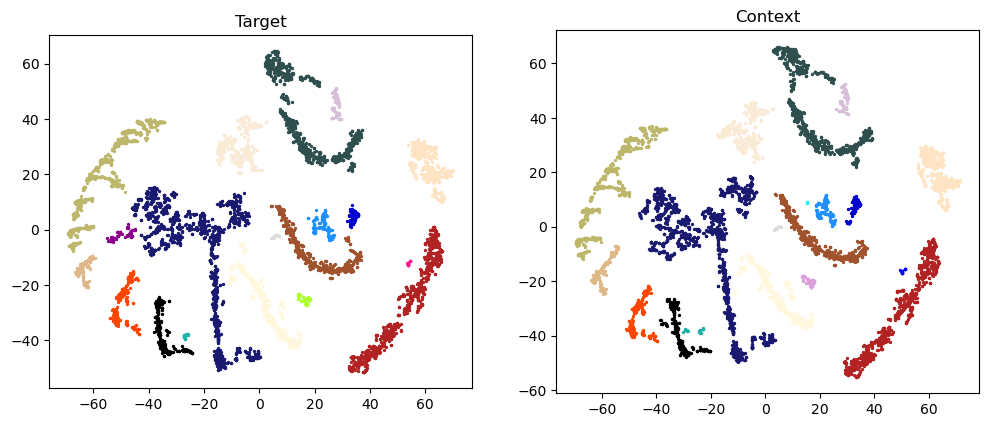

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
for i in np.unique(all_clusters):
    ax[0].scatter(trans_target_embeds[0][tar_clusters == i, 0],
                  trans_target_embeds[0][tar_clusters == i, 1],
                  label=f"Cluster-{i}", s=2, c=colors[(i+1) % len(colors)])
    ax[1].scatter(trans_contx_embeds[0][contx_clusters == i, 0],
                  trans_contx_embeds[0][contx_clusters == i, 1],
                  label=f"Cluster-{i}", s=2, c=colors[(i+1) % len(colors)])
ax[0].title.set_text("Target")
ax[0].set_aspect("equal")
# ax[1].legend()
ax[1].title.set_text("Context")
ax[1].set_aspect("equal")

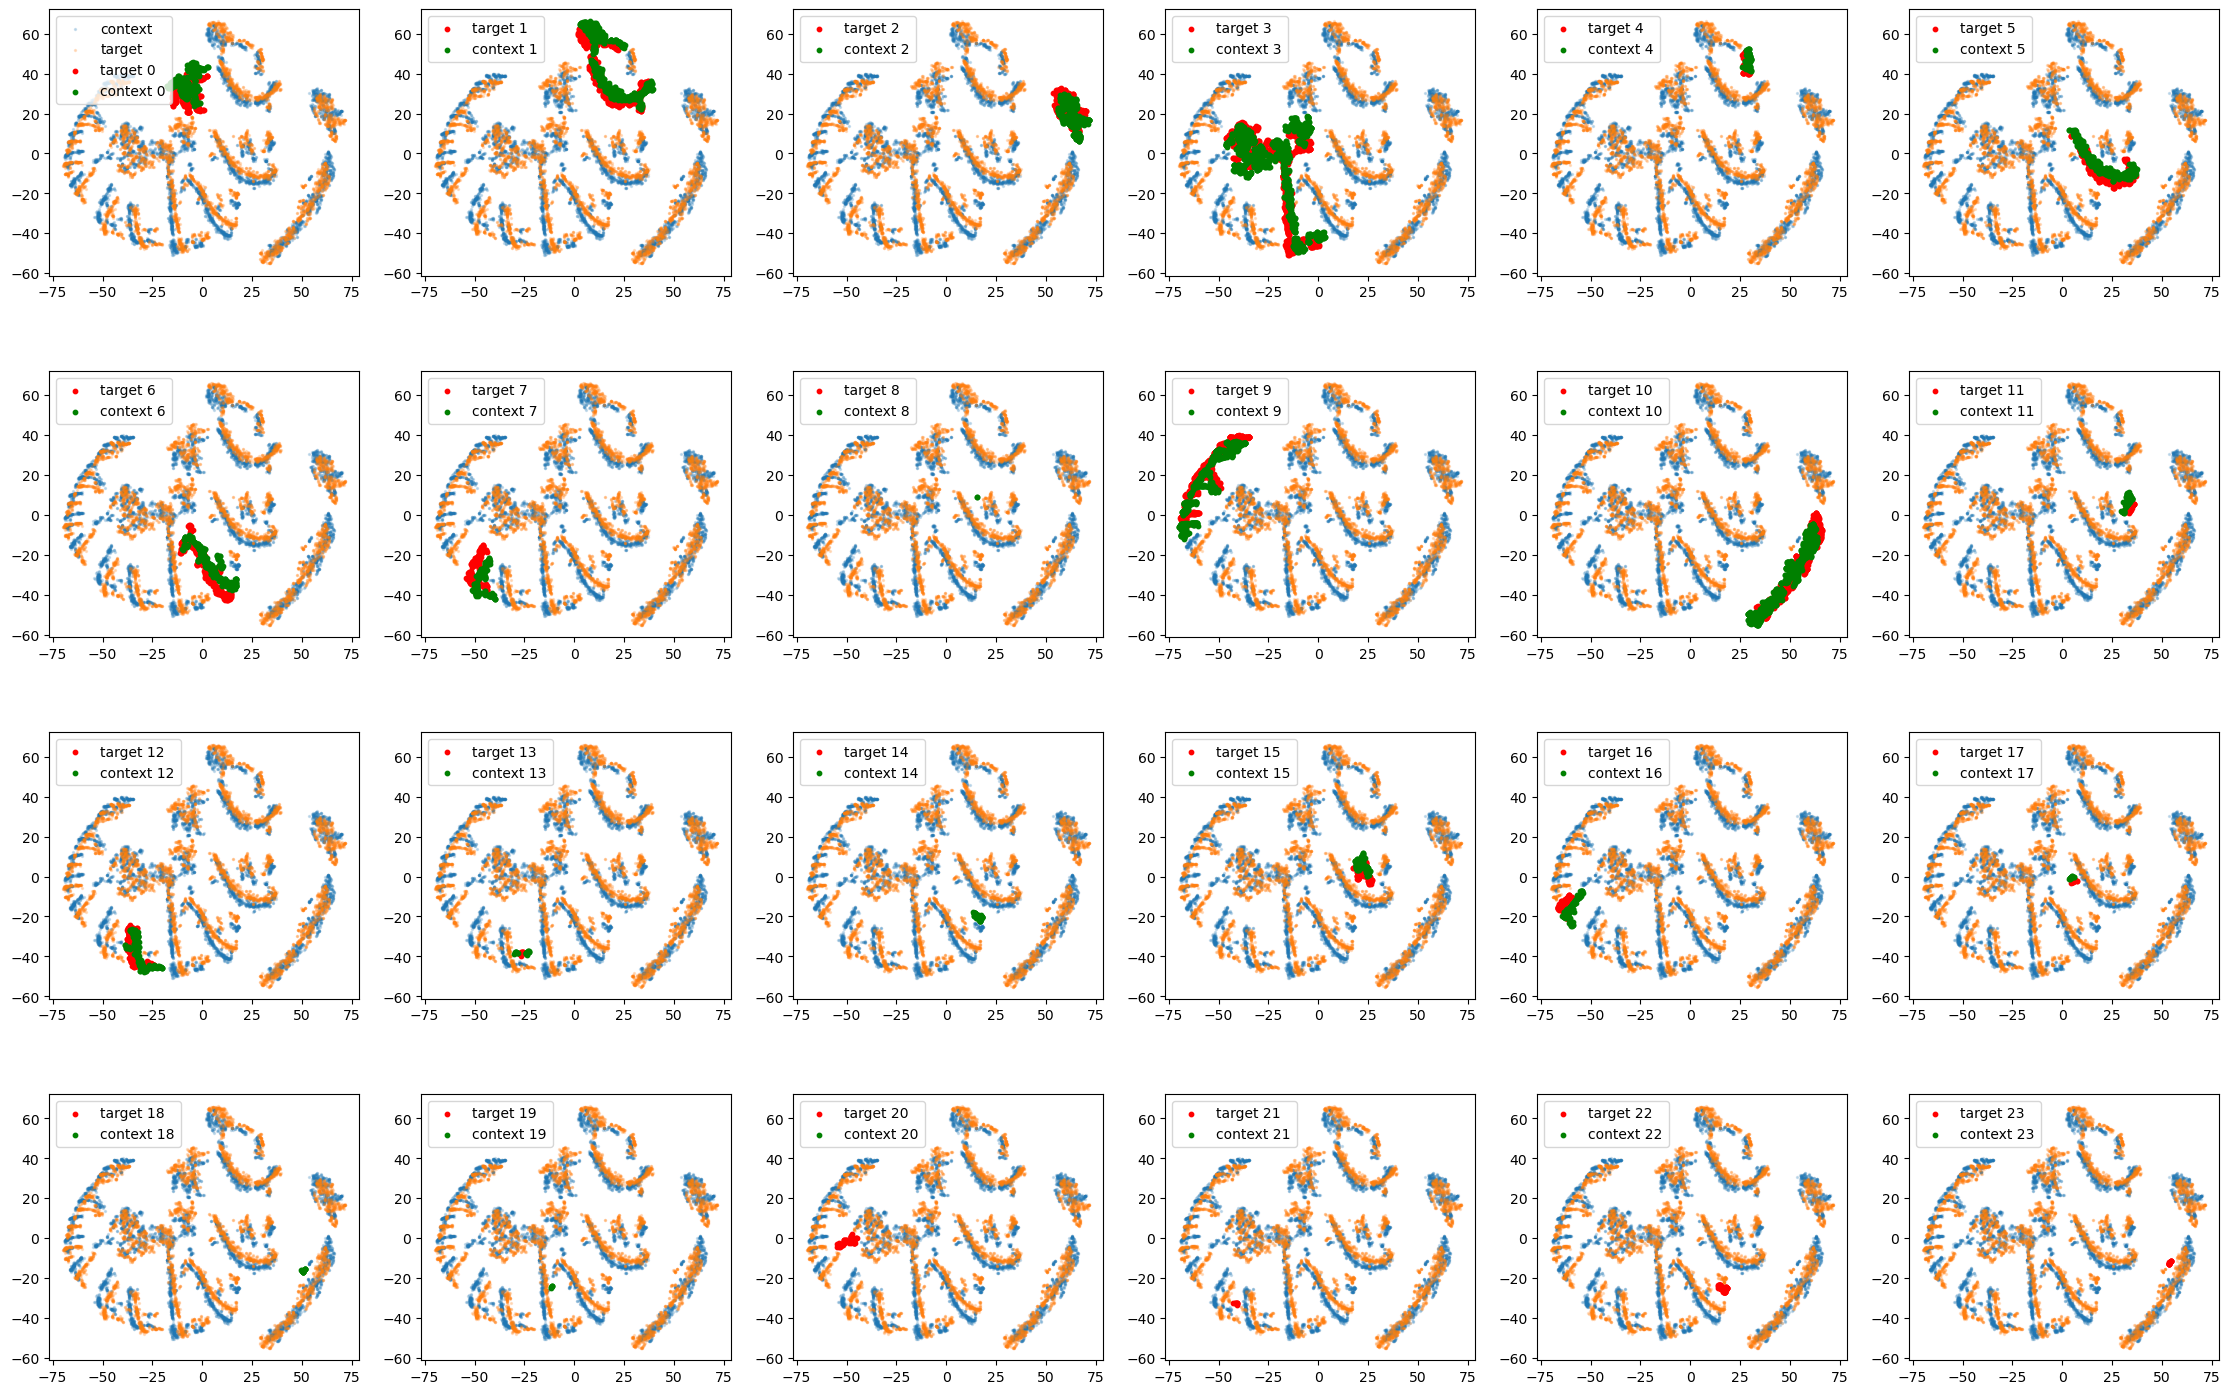

In [77]:
fig, ax = plt.subplots(4, 6, figsize=(28, 18))
ax = ax.ravel()
for i in np.unique(all_clusters):
    labels =["", ""]
    if i == 0:
        labels = ["context", "target"]
    ax[i].scatter(trans_target_embeds[0][:, 0], trans_target_embeds[0][:, 1],
                  s=2, label=labels[0], c='tab:blue', alpha=0.2)
    ax[i].scatter(trans_contx_embeds[0][:, 0], trans_contx_embeds[0][:, 1],
                  s=2, label=labels[1], c='tab:orange', alpha=0.2)
    
    ax[i].scatter(trans_target_embeds[0][tar_clusters == i, 0],
                trans_target_embeds[0][tar_clusters == i, 1], label=f"target {i}", s=10, c='red')
    ax[i].scatter(trans_contx_embeds[0][contx_clusters == i, 0],
                trans_contx_embeds[0][contx_clusters == i, 1], label=f"context {i}", s=10, c='green')
    ax[i].set_aspect("equal")
    ax[i].legend()

In [117]:
len(all_clusters)

12064

In [119]:
cluster_dir

PosixPath('/Users/yufengluo/Research/anl/su24/trainings/camera-train/world_model/model_94/inference/cluster_20')

In [121]:
import shutil

In [140]:
fn

'-0.0,-0.0,102.0_2024-06-21_04:17:54.821417'

In [146]:
(fn + ".jpg").split("_", maxsplit=1)[1]

'2024-06-21_04:17:54.821417.jpg'

In [148]:
fn

'-0.0,-0.0,102.0_2024-06-21_04:17:54.821417'

In [147]:
get_position_datetime_from_labels([fn])

(array([[ -0.,  -0., 102.]]),
 DatetimeIndex(['2024-06-21 04:17:54.821417+00:00'], dtype='datetime64[ns, UTC]', freq=None))

In [152]:
pos[:, -1]

array([201.])

In [78]:
infer_dir

PosixPath('/Users/yufengluo/Research/anl/su24/trainings/camera-train/world_model/model_94/inference')

In [154]:
for i in np.unique(contx_clusters):
    print(f"Cluster {i}: {np.count_nonzero(contx_clusters == i)}")
    # cluster_dir = infer_dir / f"cluster_{i}"
    # cluster_dir.mkdir(exist_ok=True)
    li_depth = []
    for fn in pred_fnames[contx_clusters == i]:
        pos, data_times = get_position_datetime_from_labels([fn])
        depth = pos[:, -1]
        li_depth.append(depth)
        # fpath = img_dir / (fn + ".jpg")
        # new_fpath = cluster_dir / fpath.name
        # if new_fpath.exists():
        #     new_fpath.unlink()
        # shutil.copy(fpath, new_fpath)
    print(pd.DataFrame(li_depth, columns=["depth"]).describe())

Cluster 0: 348
             depth
count   348.000000
mean    404.824713
std     364.737402
min       1.000000
25%     101.750000
50%     301.000000
75%     581.750000
max    1601.000000
Cluster 1: 738
             depth
count   738.000000
mean    359.261518
std     366.904826
min       1.000000
25%     101.000000
50%     258.500000
75%     501.000000
max    2046.000000
Cluster 2: 383
             depth
count   383.000000
mean    390.997389
std     382.461280
min       1.000000
25%     101.000000
50%     301.000000
75%     580.000000
max    2046.000000
Cluster 3: 1310
             depth
count  1310.000000
mean    365.094656
std     360.128589
min       1.000000
25%     101.000000
50%     246.000000
75%     526.000000
max    2146.000000
Cluster 4: 90
             depth
count    90.000000
mean    367.177778
std     329.973767
min       1.000000
25%     101.000000
50%     274.000000
75%     646.250000
max    1205.000000
Cluster 5: 454
             depth
count   454.000000
mean    320.58810

In [137]:
pred_fnames

array(['-0.0,-0.0,102.0_2024-06-21_04:17:54.821417',
       '-0.0,-0.19,102.0_2024-06-21_04:17:56.203611',
       '-0.07,-29.74,605.0_2024-06-21_03:25:44.067884', ...,
       '99.99,-92.0,232.0_2024-06-21_04:51:43.294089',
       '99.99,-92.0,232.0_2024-06-21_04:51:44.589454',
       '99.99,-92.39,232.0_2024-06-21_04:51:47.291323'], dtype='<U48')